In [1]:
import warnings

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

warnings.filterwarnings("ignore")

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "robust_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

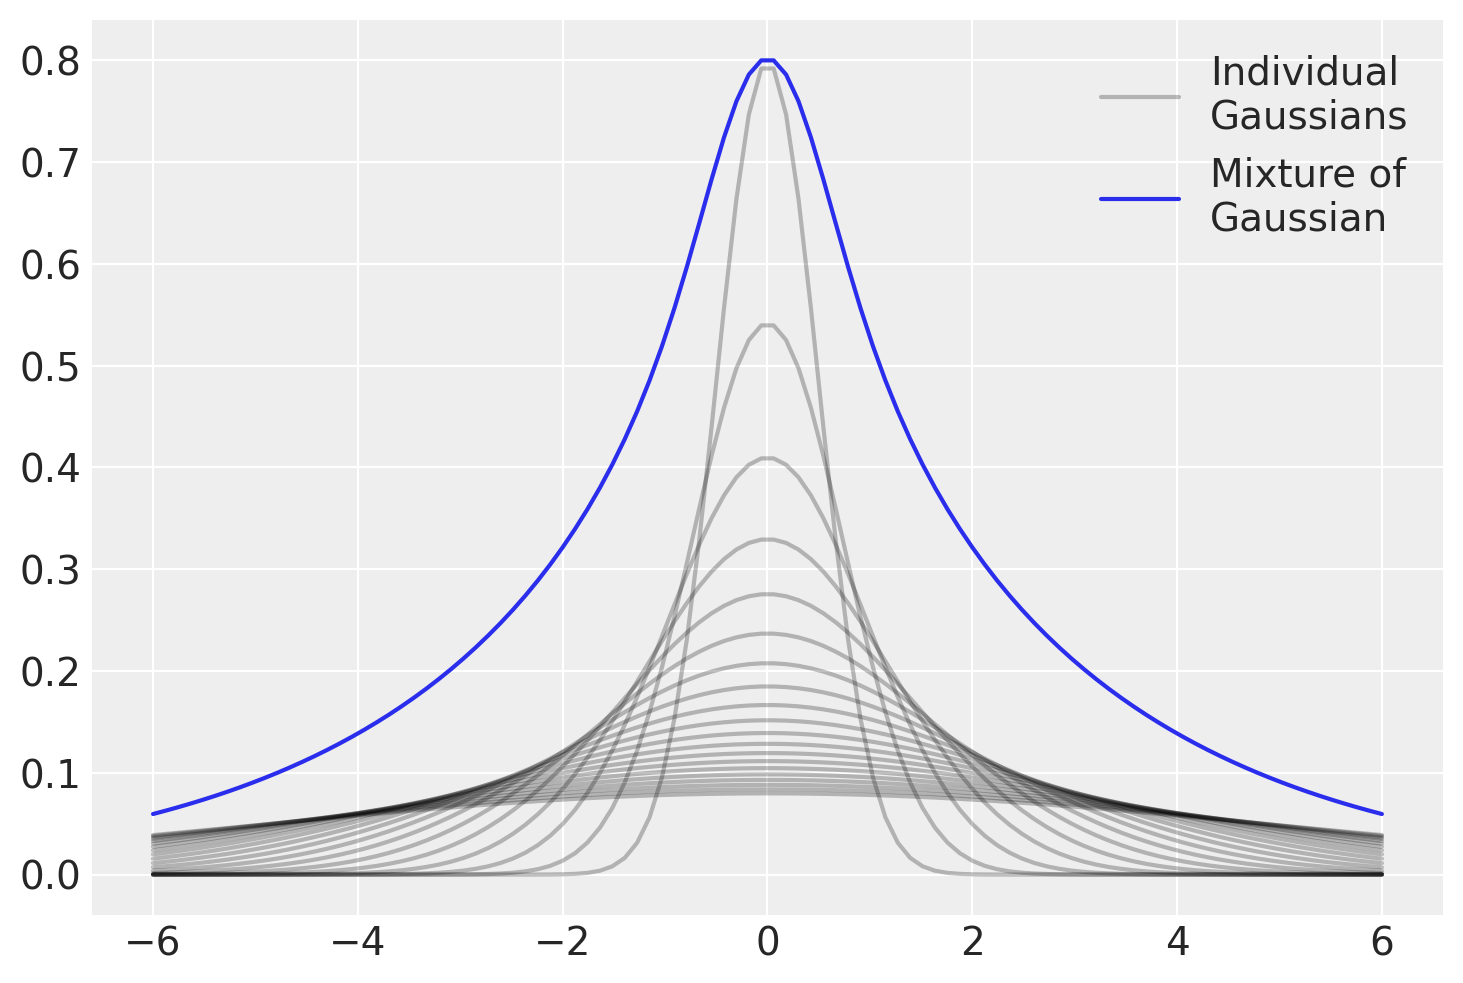

In [3]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Inizializzazione dell'array per i PDF (Probability Density Function)
pdfs = []

# Numero di gaussiane
n_gaussians = 20

# Ciclo per tracciare ogni gaussiana
for variance in np.linspace(.5, 5, n_gaussians):
    label = "Individual\nGaussians" if variance == .5 else None
    pdf = stats.norm(0, variance).pdf(xs)
    pdfs.append(pdf)
    plt.plot(xs, pdf, color='k', label=label, alpha=.25)  # Usa matplotlib.pyplot.plot

# Calcolo della somma dei PDFs
sum_of_pdfs = np.array(pdfs).sum(axis=0)
sum_of_pdfs /= sum_of_pdfs.max()
sum_of_pdfs *= (1 - n_gaussians / 100)

# Tracciare la somma dei PDFs
plt.plot(xs, sum_of_pdfs, label='Mixture of\nGaussian')

plt.legend()
plt.show()

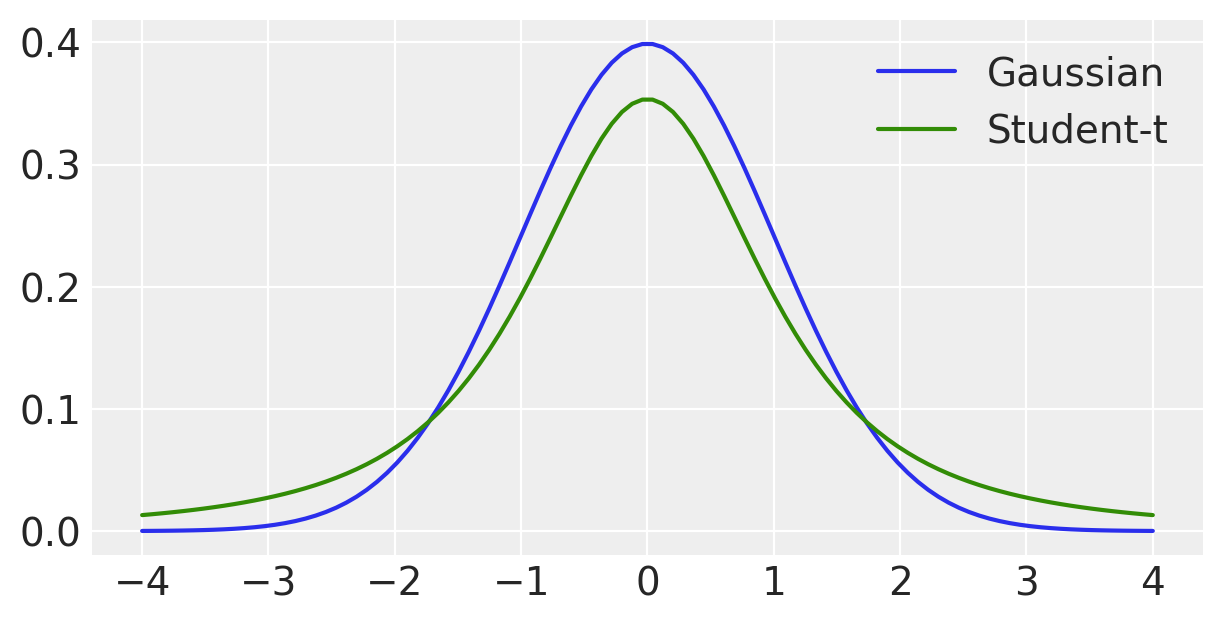

In [4]:
# Creazione dell'array di valori x
xs = np.linspace(-4, 4, 100)

# Configurazione delle dimensioni del grafico
plt.subplots(figsize=(6, 3))

# Tracciare la distribuzione normale (Gaussiana)
plt.plot(xs, stats.norm.pdf(xs), label='Gaussian')

# Tracciare la distribuzione Student-t
plt.plot(xs, stats.t(2).pdf(xs), color='C2', label='Student-t')

plt.legend()
plt.show()

In [5]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.01, 0.1, 0.15])
y_out = np.append(y, [12, 11, 13])

data = pd.DataFrame({
    "x": x_out,
    "y": y_out
})

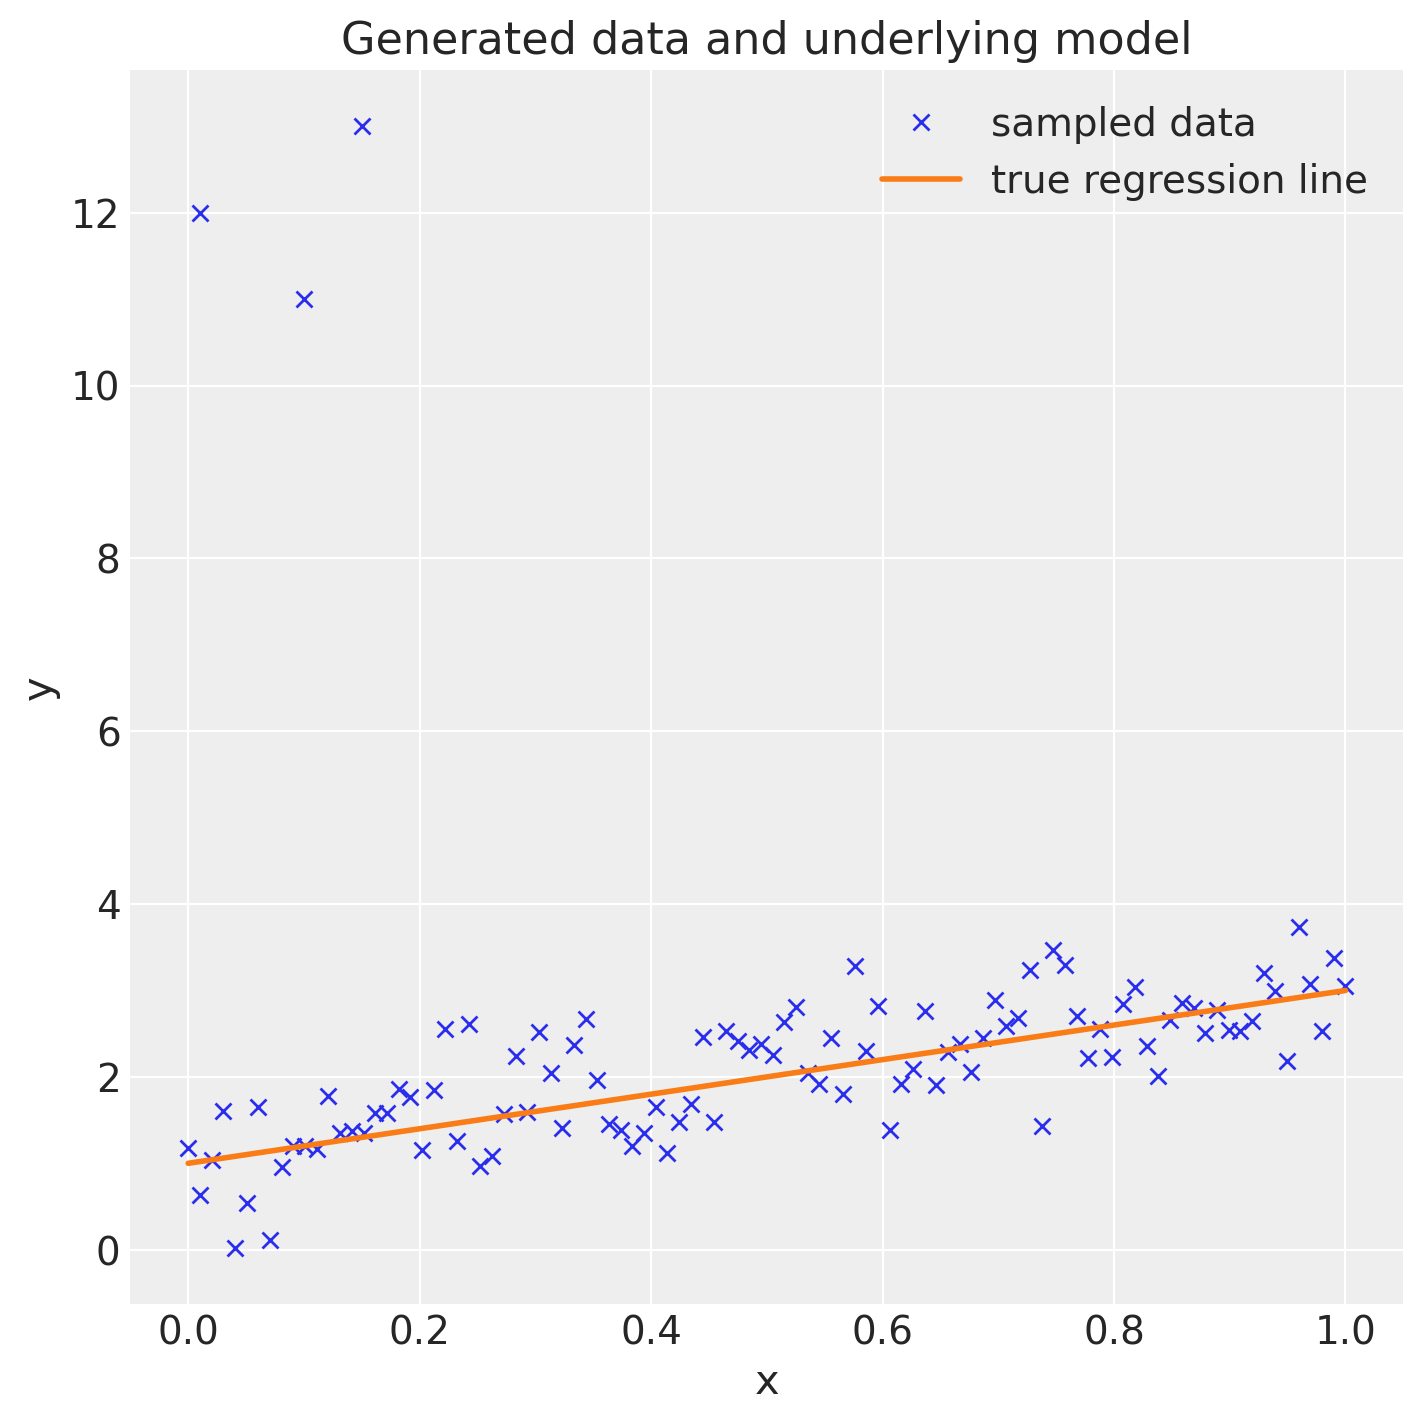

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [7]:
gauss_model = bmb.Model("y ~ x", data, family="gaussian")

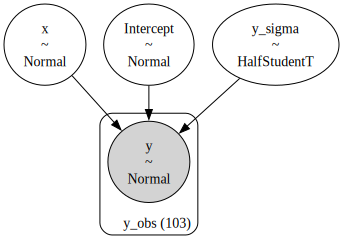

In [8]:
gauss_model.build()
gauss_model.graph()

In [9]:
gauss_fitted = gauss_model.fit(
    nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

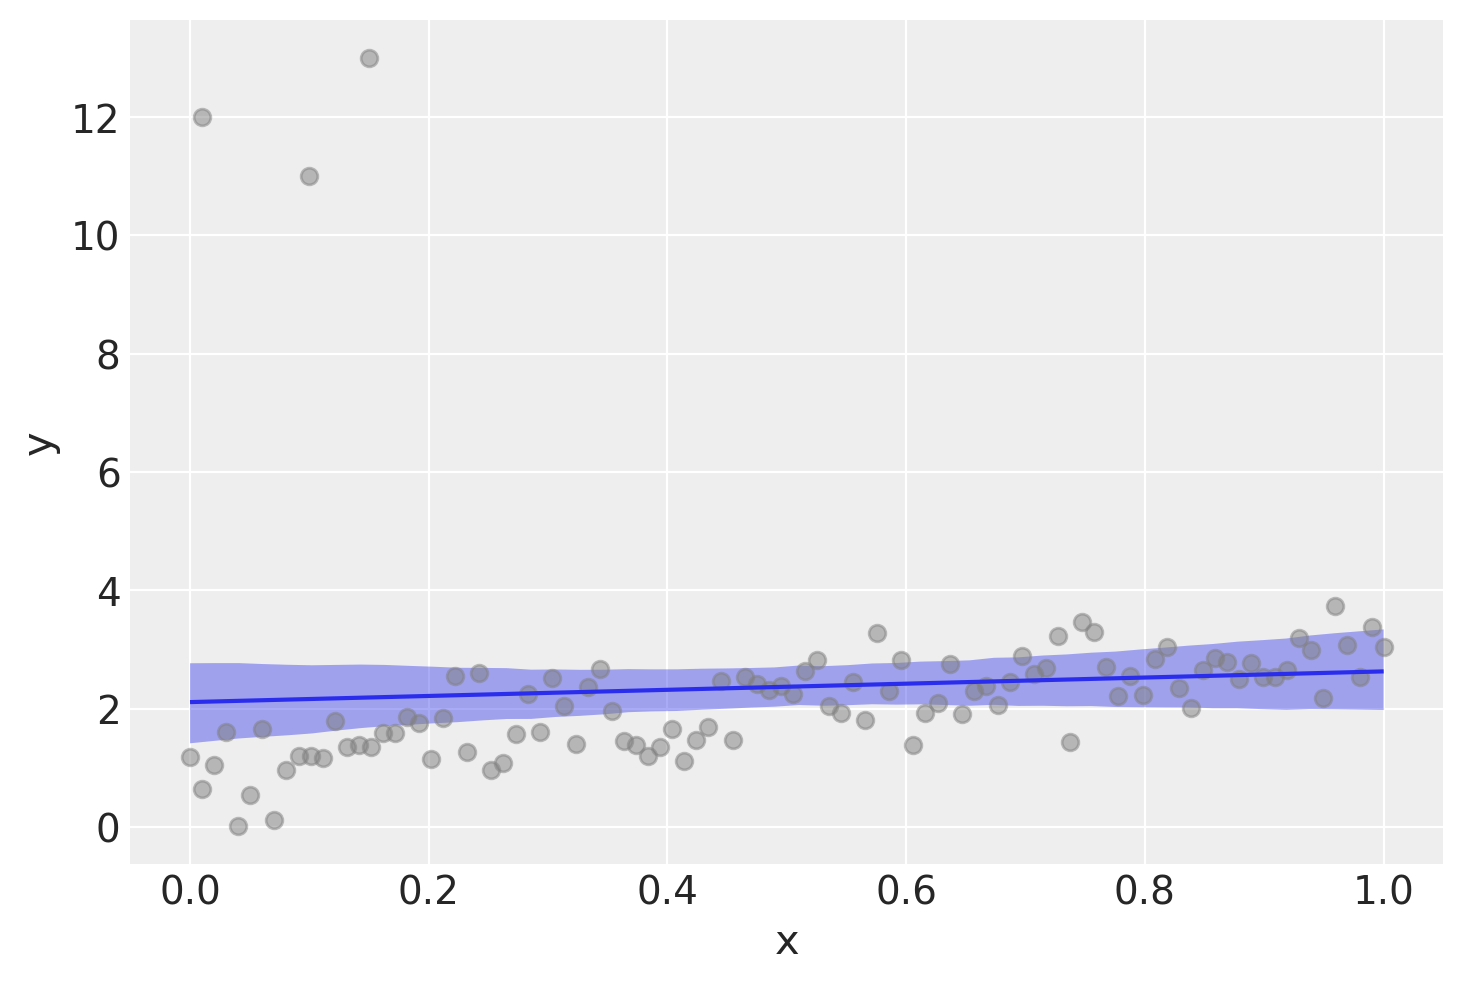

In [10]:
ax = bmb.interpret.plot_predictions(gauss_model, gauss_fitted, ["x"])
plt.scatter(data['x'], data['y'], color='gray', alpha=0.5, label='Dati Grezzi')
plt.show()

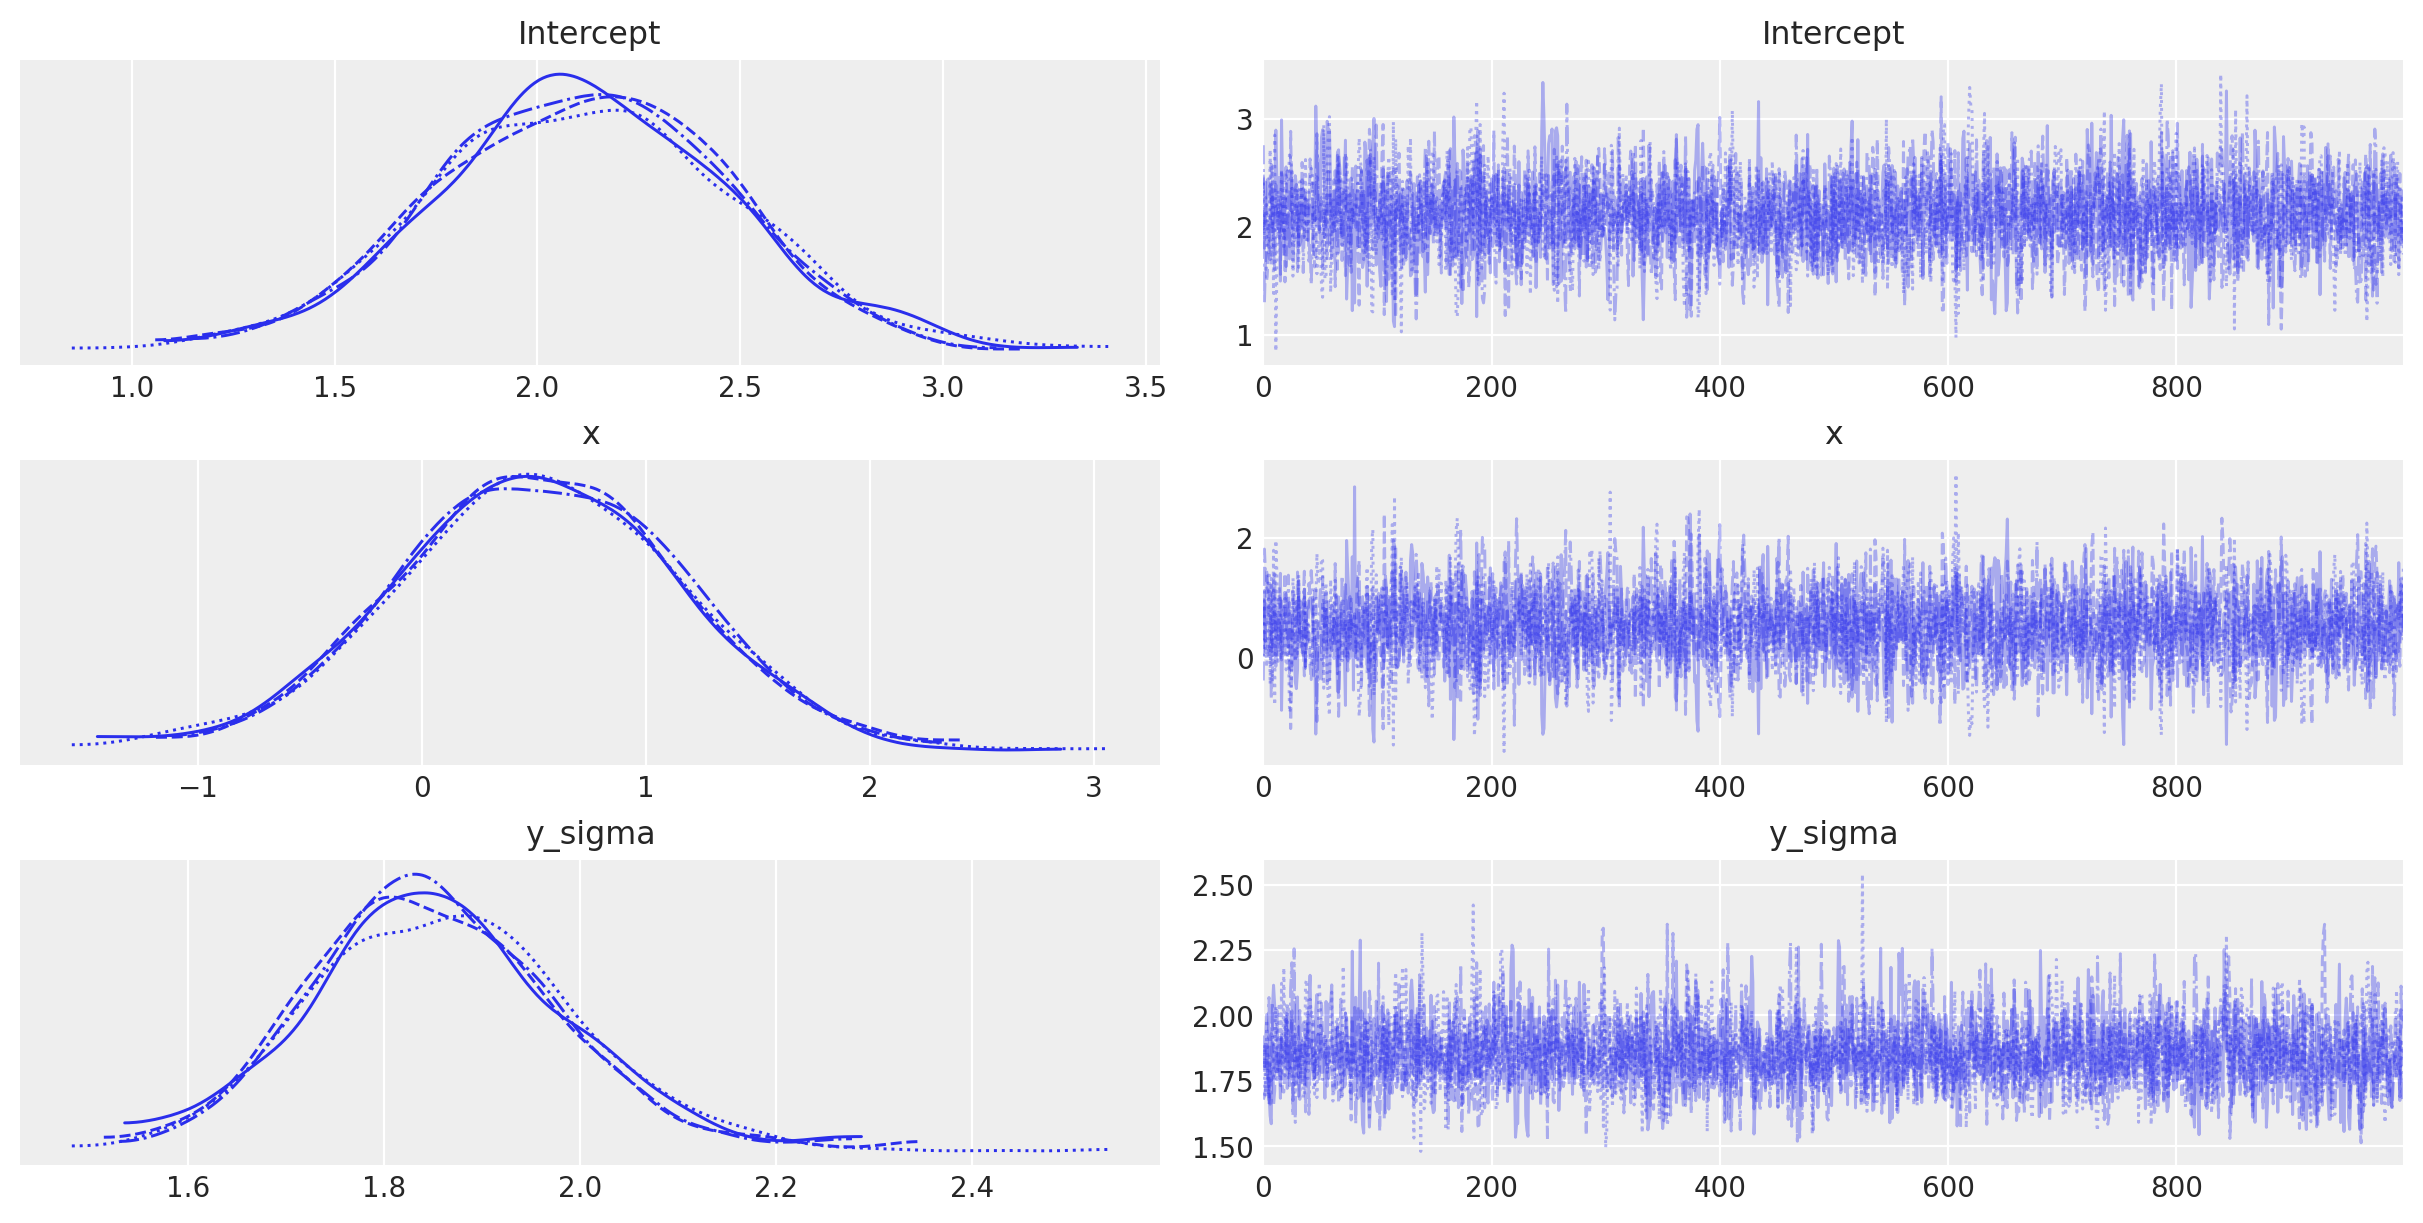

In [11]:
_ = az.plot_trace(gauss_fitted)

In [12]:
az.summary(gauss_fitted, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.11,0.36,1.41,2.77,0.01,0.00,3481.39,2498.19,1.0
x,0.52,0.63,-0.68,1.69,0.01,0.01,3421.91,2828.17,1.0
y_sigma,1.86,0.13,1.61,2.10,0.00,0.00,3902.21,2745.68,1.0


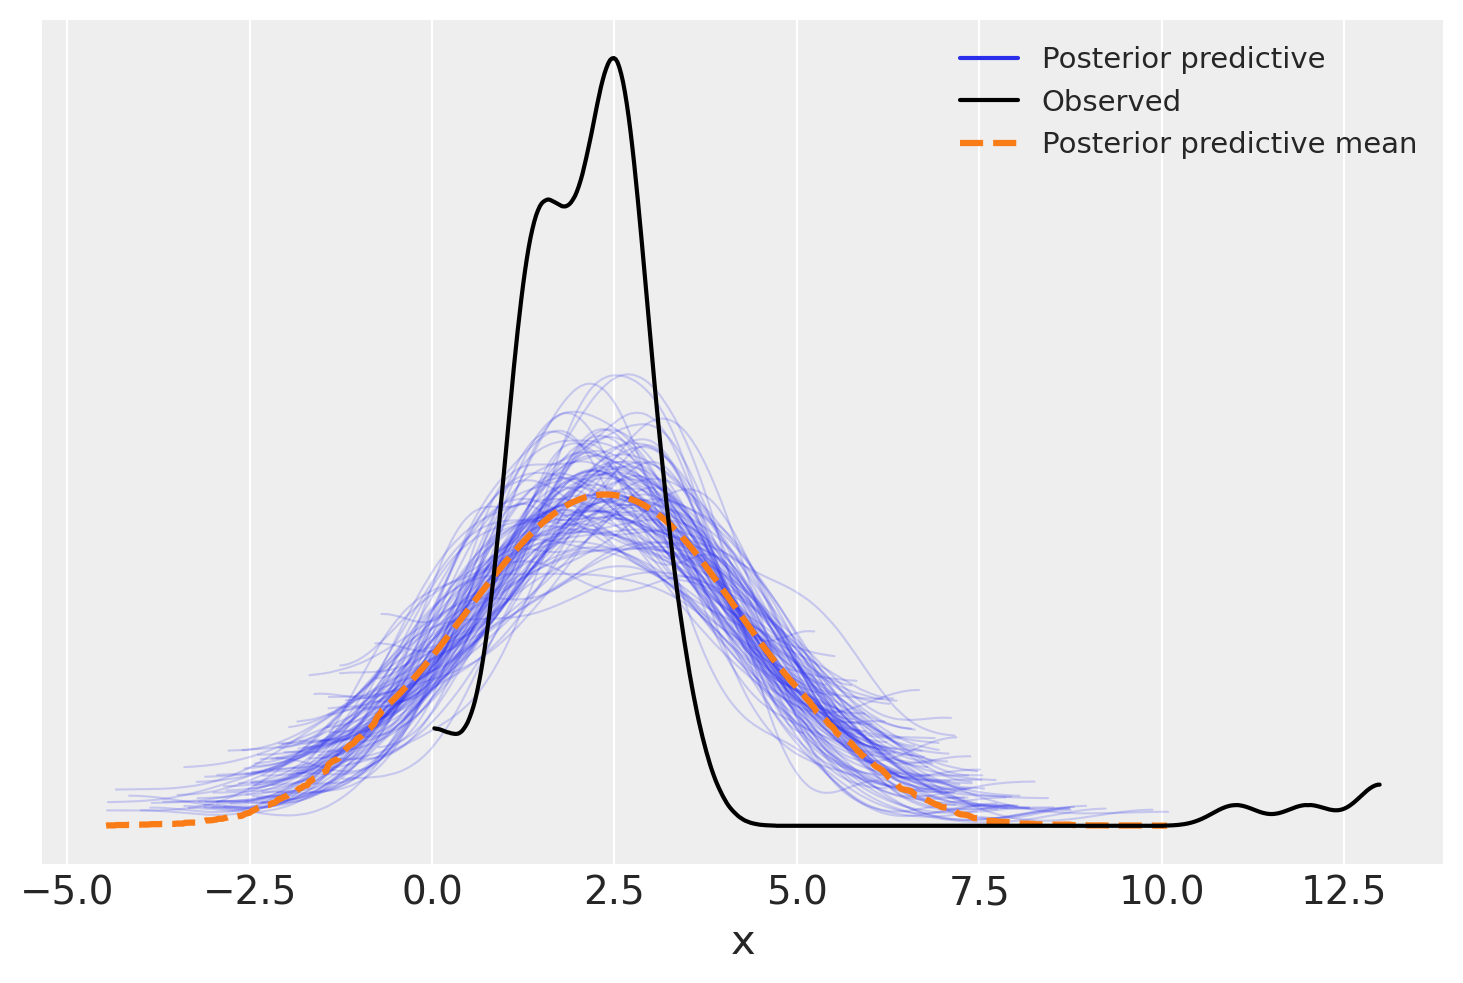

In [13]:
posterior_predictive = gauss_model.predict(gauss_fitted, kind="pps")
ax = az.plot_ppc(gauss_fitted, num_pp_samples=100)
_ = ax.set_xlabel("x")

In [14]:
t_model = bmb.Model("y ~ x", data, family="t")

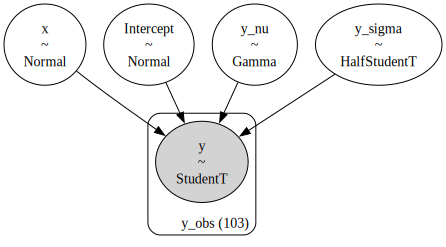

In [15]:
t_model.build()
t_model.graph()

In [16]:
t_fitted = t_model.fit(
    nuts_sampler="numpyro",
    idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

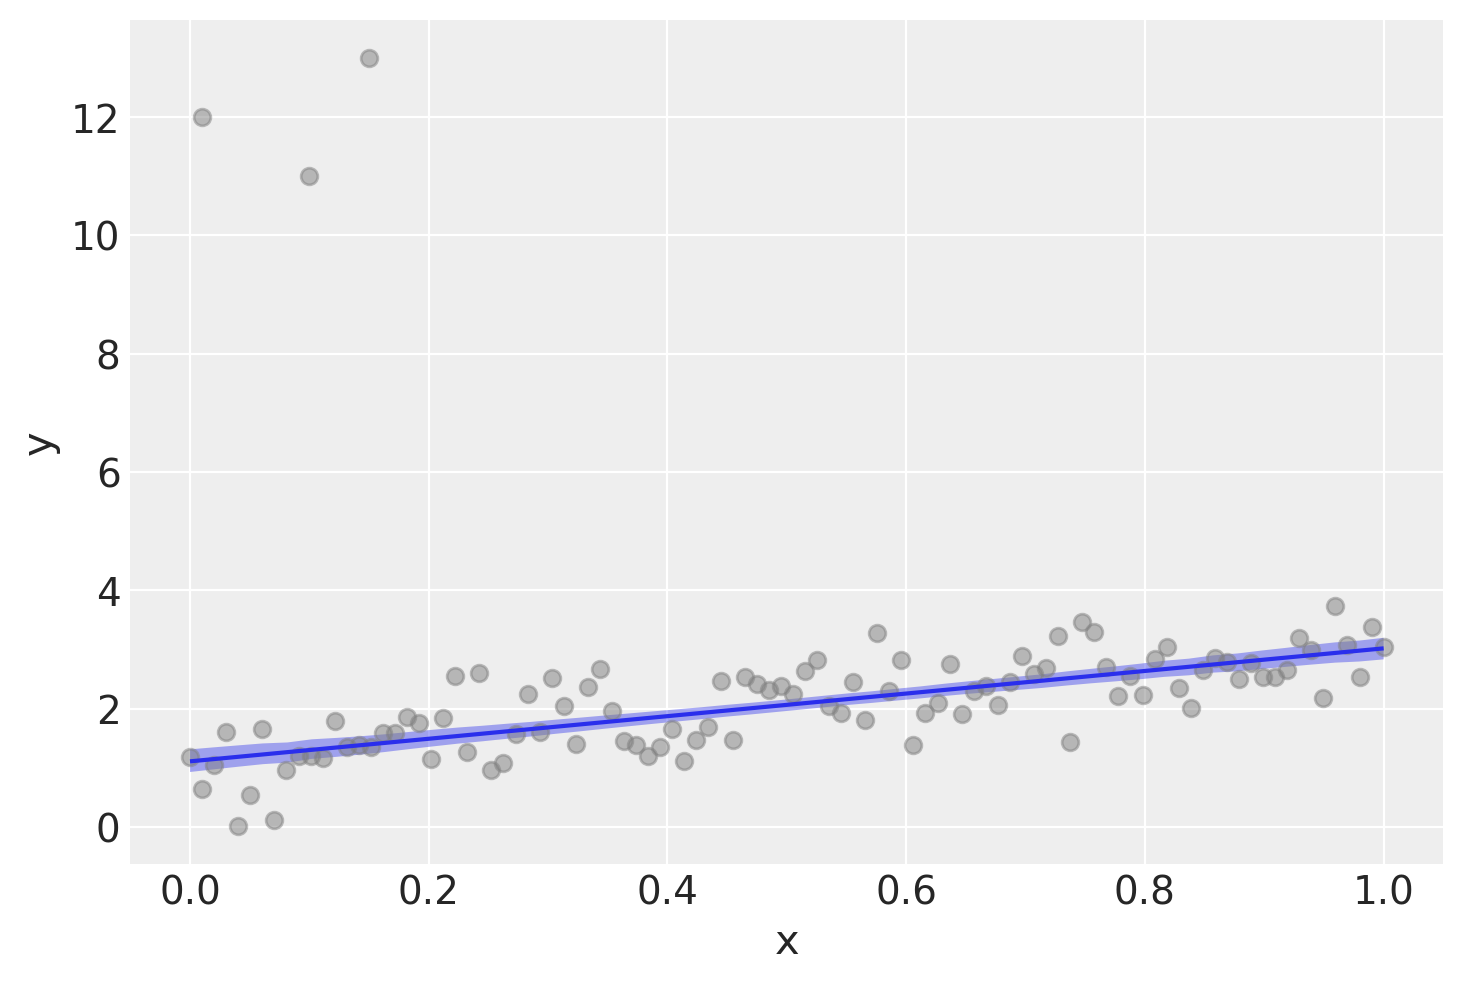

In [17]:
ax = bmb.interpret.plot_predictions(t_model, t_fitted, ["x"])
_ = plt.scatter(data['x'], data['y'], color='gray', alpha=0.5, label='Dati Grezzi')

In [18]:
az.summary(t_fitted, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.11,0.10,0.93,1.31,0.00,0.00,3514.58,2762.69,1.0
x,1.91,0.17,1.59,2.23,0.00,0.00,3648.92,2905.87,1.0
y_nu,2.13,0.45,1.36,2.99,0.01,0.01,3399.76,2758.75,1.0
y_sigma,0.40,0.05,0.31,0.48,0.00,0.00,3532.58,2722.48,1.0


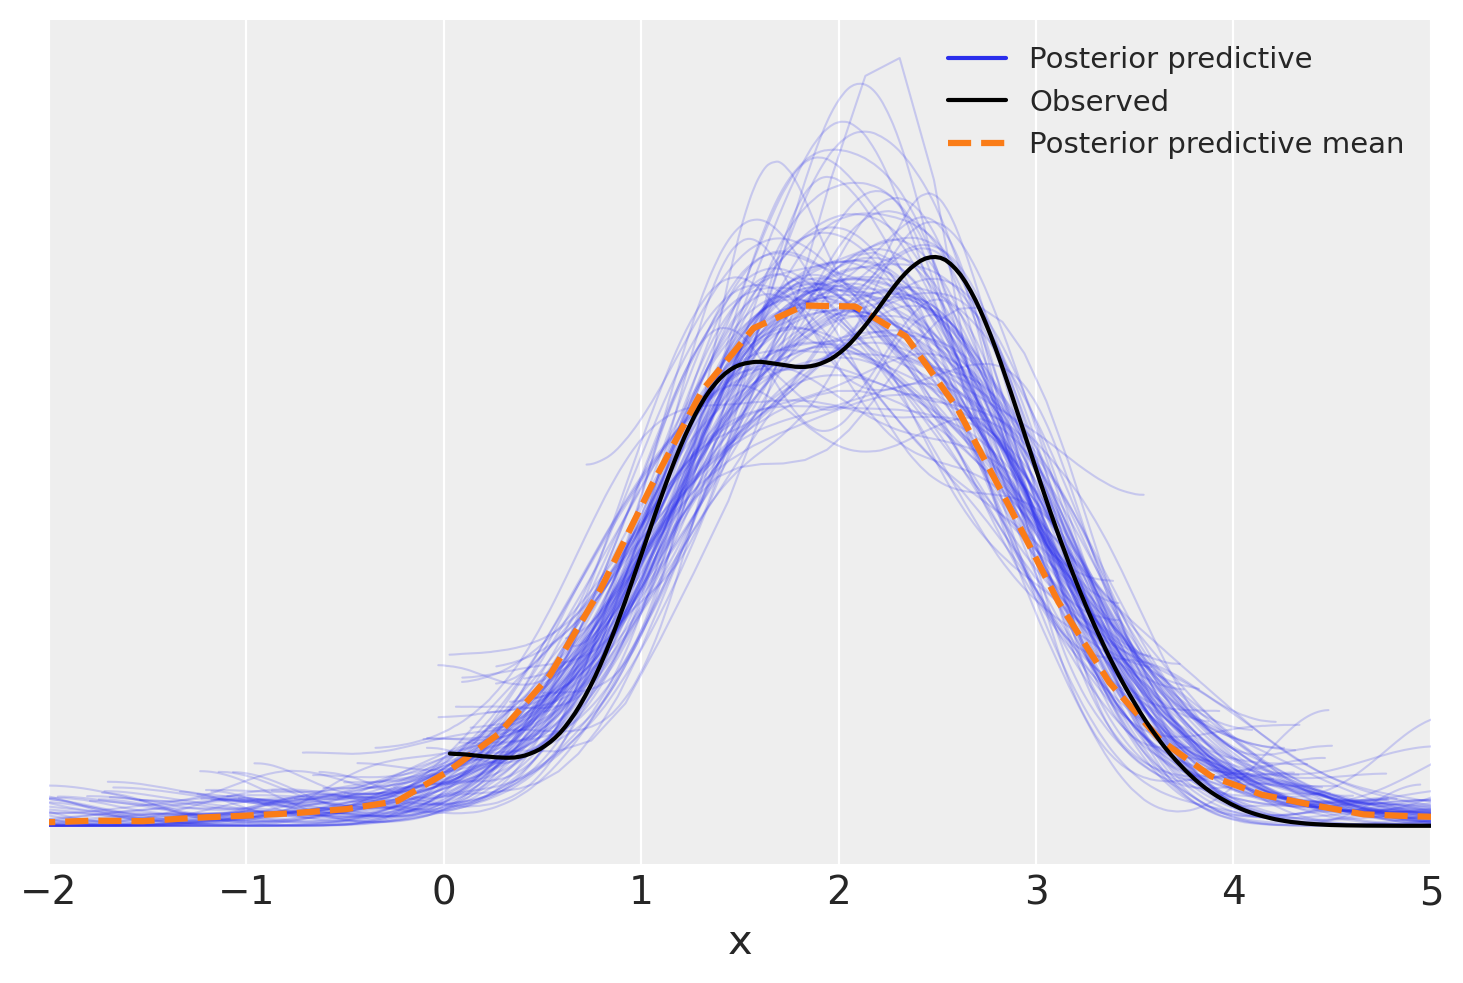

In [19]:
posterior_predictive = t_model.predict(t_fitted, kind="pps")
ax = az.plot_ppc(t_fitted, num_pp_samples=100)
plt.xlim(-2, 5)
_ = ax.set_xlabel("x")

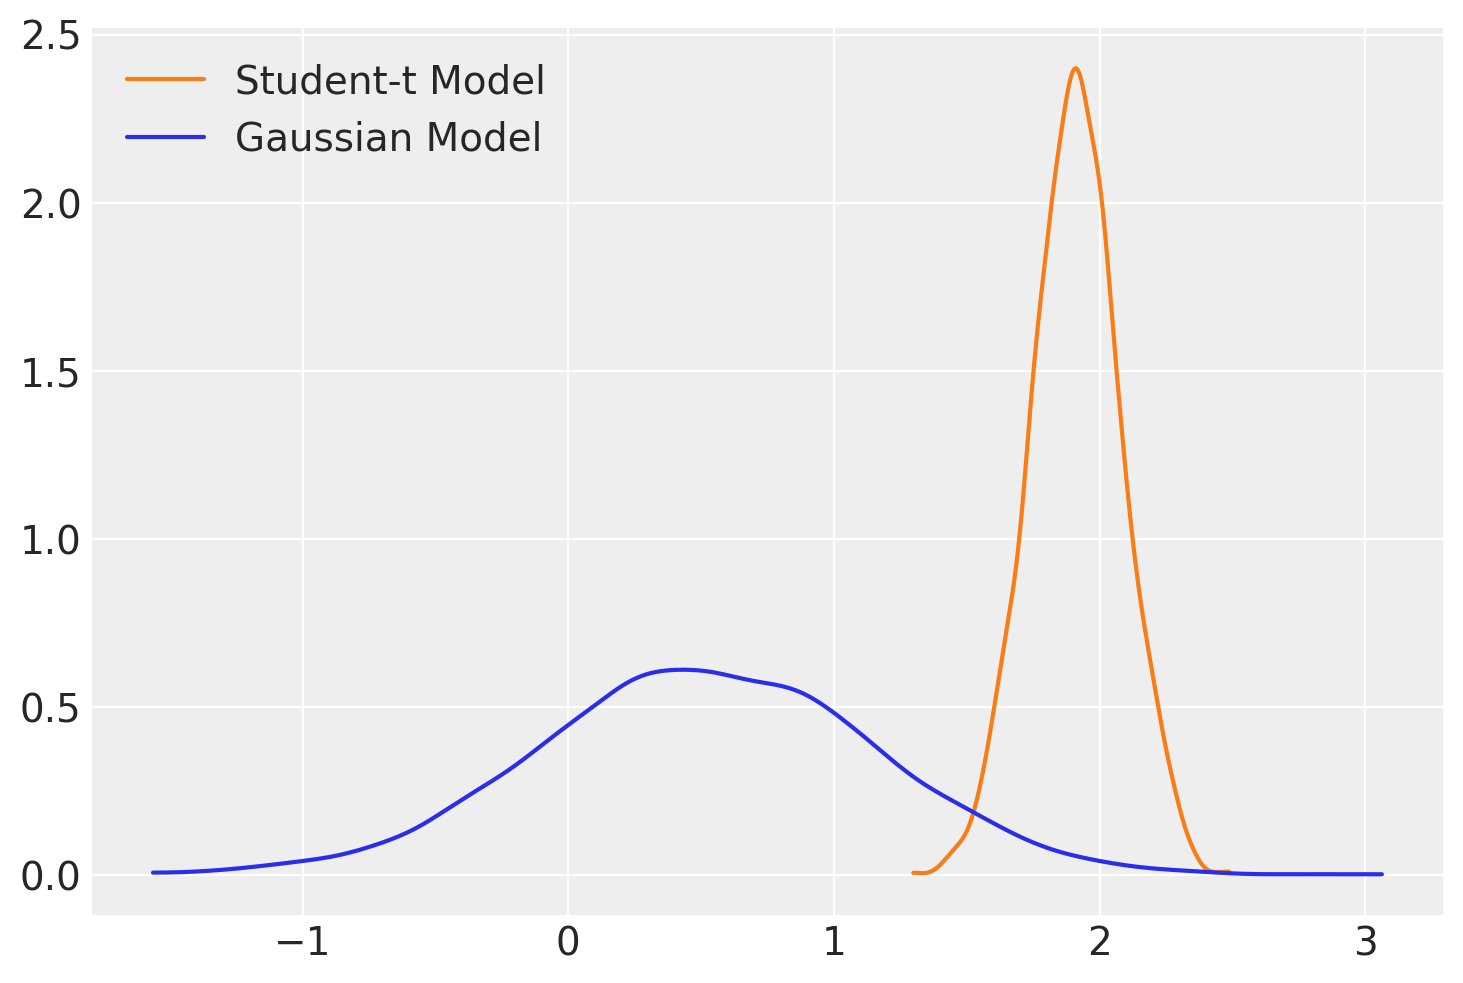

In [20]:
az.plot_dist(t_fitted.posterior["x"], color="C1", label="Student-t Model")
az.plot_dist(gauss_fitted.posterior["x"], label="Gaussian Model");

In [21]:
az.loo(gauss_fitted)

Computed from 4000 posterior samples and 103 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -218.88    30.02
p_loo       15.43        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100   97.1%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         1    1.0%
   (1, Inf)   (very bad)    1    1.0%

In [22]:
az.loo(t_fitted)

Computed from 4000 posterior samples and 103 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -109.82    16.55
p_loo        5.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      101   98.1%
 (0.5, 0.7]   (ok)          2    1.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
def plot_loocv(inference, title=None, outliers_idx=[], divorce=None):
    plt.subplots(figsize=(6, 3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    plt.scatter(pareto_k, waic, color='C0', label=None)

    # Assicurati che outliers_idx e divorce siano definiti
    for oi in outliers_idx:
        if divorce is not None and oi in divorce.index:
            plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + .01, waic[oi]), fontsize=14)

    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC")
    plt.title(title)
    plt.show()

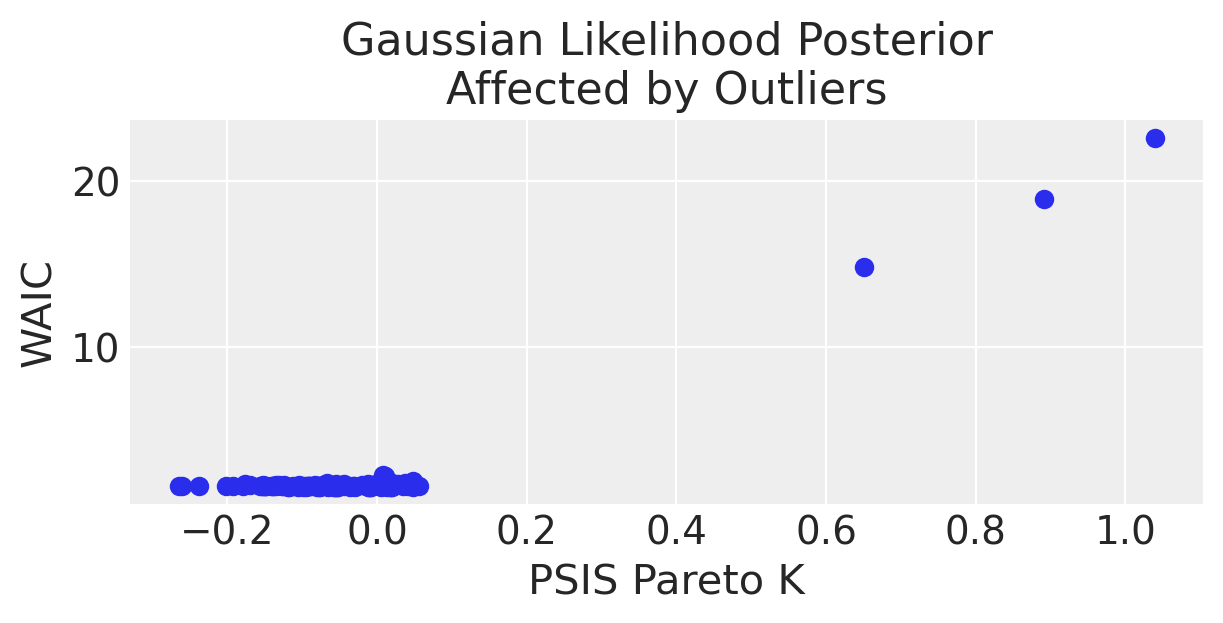

In [24]:
plot_loocv(gauss_fitted, title="Gaussian Likelihood Posterior\nAffected by Outliers")

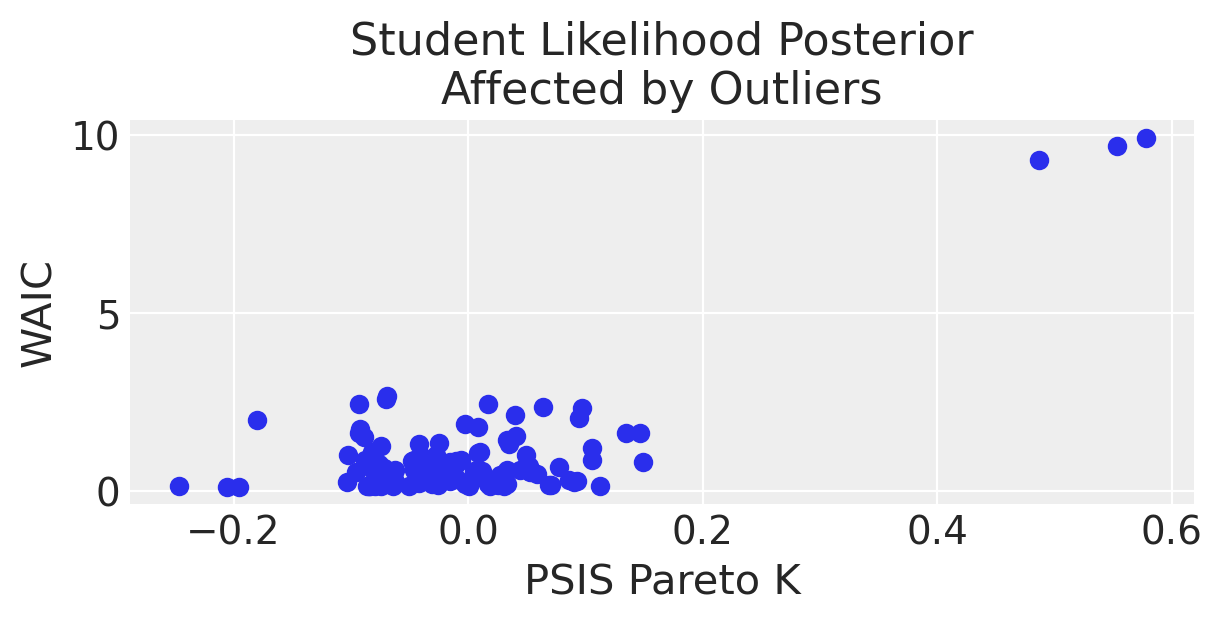

In [25]:
plot_loocv(t_fitted, title="Student Likelihood Posterior\nAffected by Outliers")

In [26]:
df_comp_loo = az.compare({"Gaussian Model": gauss_fitted, "Student t Model": t_fitted})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student t Model,0,-109.821000,5.256997,0.000000,1.0,16.545609,0.000000,False,log
Gaussian Model,1,-218.880409,15.431758,109.059409,0.0,30.021033,16.409153,True,log


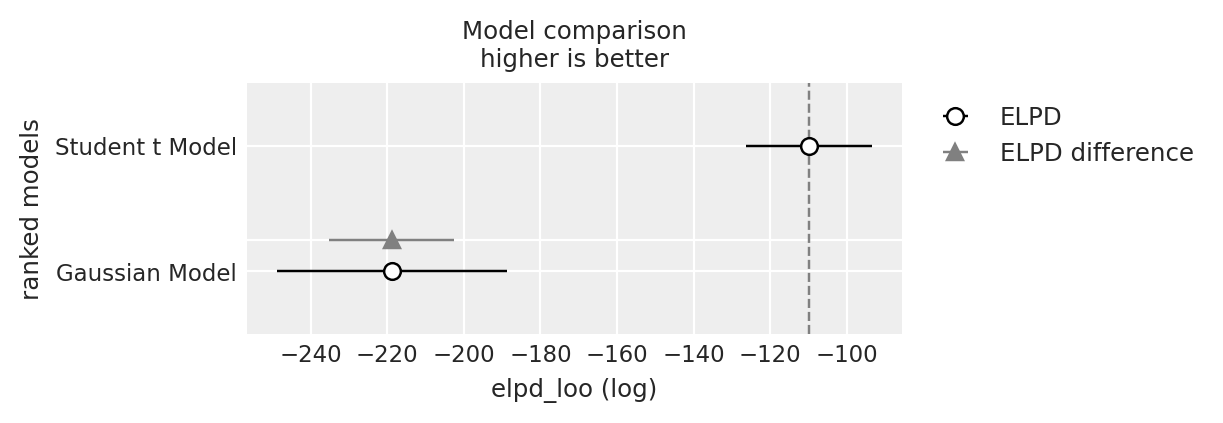

In [27]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.4
arviz     : 0.18.0
pandas    : 2.2.2
scipy     : 1.13.1
bambi     : 0.13.0
numpy     : 1.26.4

Watermark: 2.4.3

